<h1><center>VAE</center></h1>

[The original VAE paper](https://arxiv.org/abs/1312.6114)

[Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)

[Generating Large Images from Latent Vectors](https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/)

[Variational Autoencoder in TensorFlow](https://jmetzen.github.io/2015-11-27/vae.html)

In [2]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
# Dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = int(np.sqrt(input_dim))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
class Autoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()        
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        self.z = fc(f3, self.n_z, scope='enc_fc4', activation_fn=tf.nn.relu)

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Optimizer
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.recon_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss
        }
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z    

In [9]:
def trainer(model_class, learning_rate=1e-4, 
            batch_size=64, num_epoch=100, n_z=16, log_step=5):
    # Create a model    
    model = model_class(
        learning_rate=learning_rate, batch_size=batch_size, n_z=n_z)

    # Training loop    
    for epoch in range(num_epoch):
        start_time = time.time()
        
        # Run an epoch
        for iter in range(num_sample // batch_size):
            # Get a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and backward pass 
            # Report computed loss
            losses = model.run_single_step(batch[0])
        end_time = time.time()
        
        # Log the loss
        if epoch % log_step == 0:
            log_str = '[Epoch {}] '.format(epoch)
            for k, v in losses.items():
                log_str += '{}: {:.3f}  '.format(k, v)
            log_str += '({:.3f} sec/epoch)'.format(end_time - start_time)
            print(log_str)
            
    print('Done!')
    return model

In [10]:
# Train a model
model = trainer(Autoencoder)

[Epoch 0] recon_loss: 154.911  (3.054 sec/epoch)
[Epoch 5] recon_loss: 101.669  (1.372 sec/epoch)
[Epoch 10] recon_loss: 101.650  (1.066 sec/epoch)
[Epoch 15] recon_loss: 85.099  (1.736 sec/epoch)
[Epoch 20] recon_loss: 88.686  (1.543 sec/epoch)


[Epoch 25] recon_loss: 85.773  (1.704 sec/epoch)
[Epoch 30] recon_loss: 82.263  (1.749 sec/epoch)
[Epoch 35] recon_loss: 78.678  (2.842 sec/epoch)
[Epoch 40] recon_loss: 83.202  (1.902 sec/epoch)
[Epoch 45] recon_loss: 84.160  (1.969 sec/epoch)
[Epoch 50] recon_loss: 80.650  (2.317 sec/epoch)
[Epoch 55] recon_loss: 80.194  (2.052 sec/epoch)
[Epoch 60] recon_loss: 76.316  (2.282 sec/epoch)
[Epoch 65] recon_loss: 82.402  (3.254 sec/epoch)
[Epoch 70] recon_loss: 80.494  (2.068 sec/epoch)
[Epoch 75] recon_loss: 80.096  (2.040 sec/epoch)
[Epoch 80] recon_loss: 83.276  (1.697 sec/epoch)
[Epoch 85] recon_loss: 74.038  (1.219 sec/epoch)
[Epoch 90] recon_loss: 70.322  (0.988 sec/epoch)
[Epoch 95] recon_loss: 78.715  (1.721 sec/epoch)
Done!


In [11]:
def test_reconstruction(model, mnist, h=28, w=28, batch_size=100):
    # Test the trained model: reconstruction
    batch = mnist.test.next_batch(batch_size)
    x_reconstructed = model.reconstructor(batch[0])

    n = np.sqrt(batch_size).astype(np.int32)
    I_reconstructed = np.empty((h*n, 2*w*n))
    for i in range(n):
        for j in range(n):
            x = np.concatenate(
                (x_reconstructed[i*n+j, :].reshape(h, w), 
                 batch[0][i*n+j, :].reshape(h, w)),
                axis=1
            )
            I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

    plt.figure(figsize=(10, 20))
    plt.imshow(I_reconstructed, cmap='gray')

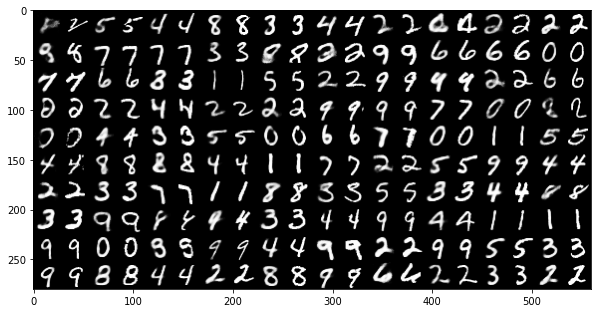

In [12]:
test_reconstruction(model, mnist)

In [13]:
# Train a model with 2d latent space
model_2d = trainer(Autoencoder, n_z=2)

/home/levon/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] recon_loss: 205.435  (1.998 sec/epoch)
[Epoch 5] recon_loss: 193.524  (1.036 sec/epoch)
[Epoch 10] recon_loss: 175.402  (1.129 sec/epoch)
[Epoch 15] recon_loss: 170.458  (2.181 sec/epoch)
[Epoch 20] recon_loss: 165.225  (2.194 sec/epoch)
[Epoch 25] recon_loss: 166.997  (1.880 sec/epoch)
[Epoch 30] recon_loss: 150.459  (1.759 sec/epoch)
[Epoch 35] recon_loss: 141.220  (1.726 sec/epoch)
[Epoch 40] recon_loss: 147.360  (0.900 sec/epoch)
[Epoch 45] recon_loss: 134.962  (1.374 sec/epoch)
[Epoch 50] recon_loss: 143.522  (2.593 sec/epoch)
[Epoch 55] recon_loss: 139.862  (1.232 sec/epoch)
[Epoch 60] recon_loss: 129.201  (1.445 sec/epoch)
[Epoch 65] recon_loss: 136.088  (0.916 sec/epoch)
[Epoch 70] recon_loss: 142.417  (1.982 sec/epoch)
[Epoch 75] recon_loss: 144.579  (1.388 sec/epoch)
[Epoch 80] recon_loss: 126.861  (2.357 sec/epoch)
[Epoch 85] recon_loss: 131.517  (1.614 sec/epoch)
[Epoch 90] recon_loss: 127.302  (2.180 sec/epoch)
[Epoch 95] recon_loss: 134.710  (1.509 sec/epoch)
Do

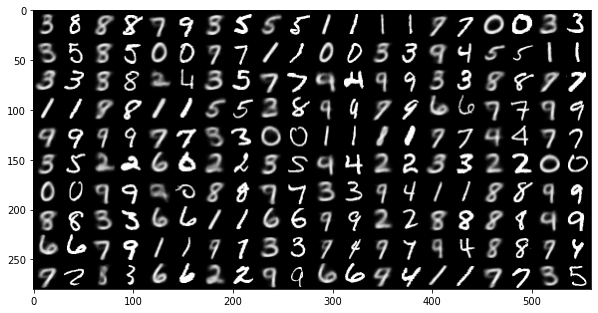

In [14]:
test_reconstruction(model_2d, mnist)

In [15]:
def test_transformation(model_2d, mnist, batch_size=3000):
    # Test the trained model: transformation
    assert model_2d.n_z == 2
    batch = mnist.test.next_batch(batch_size)
    z = model_2d.transformer(batch[0])
    plt.figure(figsize=(10, 8)) 
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1), s=20)
    plt.colorbar()
    plt.grid()

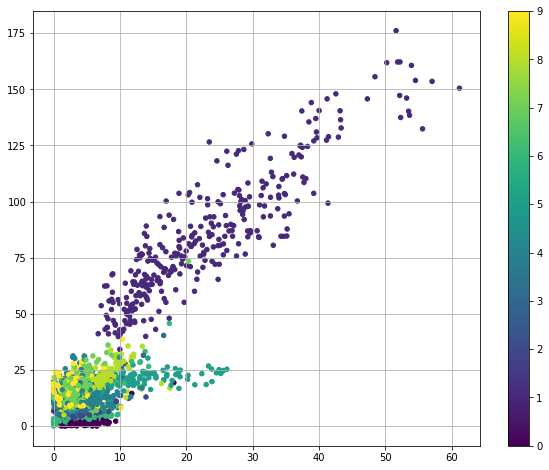

In [16]:
test_transformation(model_2d, mnist)

## Variantional Autoencoder

In [18]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-4, batch_size=64, n_z=16):
        # Set hyperparameters
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        # Build the graph
        self.build()

        # Initialize paramters
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        tf.reset_default_graph()
        self.x = tf.placeholder(
            name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 256, scope='enc_fc1', activation_fn=tf.nn.relu)
        f2 = fc(f1, 128, scope='enc_fc2', activation_fn=tf.nn.relu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.relu)
        
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu',  activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma',  activation_fn=None)
        eps = tf.random_normal(
            shape=tf.shape(self.z_log_sigma_sq),
            mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 64, scope='dec_fc1', activation_fn=tf.nn.relu)
        g2 = fc(g1, 128, scope='dec_fc2', activation_fn=tf.nn.relu)
        g3 = fc(g2, 256, scope='dec_fc3', activation_fn=tf.nn.relu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', 
                        activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + 
            (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # KL divergence: measure the difference between two distributions
        # Here we measure the divergence between 
        # the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - 
            tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = self.recon_loss + self.latent_loss
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        
        self.losses = {
            'recon_loss': self.recon_loss,
            'latent_loss': self.latent_loss,
            'total_loss': self.total_loss,
        }        
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, losses = self.sess.run(
            [self.train_op, self.losses],
            feed_dict={self.x: x}
        )
        return losses

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [19]:
# Train a vae model
model_vae = trainer(VariantionalAutoencoder)

[Epoch 0] recon_loss: 185.175  latent_loss: 5.713  total_loss: 190.888  (1.360 sec/epoch)
[Epoch 5] recon_loss: 118.032  latent_loss: 16.114  total_loss: 134.145  (1.849 sec/epoch)
[Epoch 10] recon_loss: 103.638  latent_loss: 17.583  total_loss: 121.222  (1.228 sec/epoch)
[Epoch 15] recon_loss: 96.611  latent_loss: 18.674  total_loss: 115.285  (1.378 sec/epoch)
[Epoch 20] recon_loss: 102.683  latent_loss: 18.939  total_loss: 121.622  (1.170 sec/epoch)
[Epoch 25] recon_loss: 95.806  latent_loss: 19.334  total_loss: 115.140  (1.907 sec/epoch)
[Epoch 30] recon_loss: 85.533  latent_loss: 19.041  total_loss: 104.574  (1.280 sec/epoch)
[Epoch 35] recon_loss: 91.506  latent_loss: 19.837  total_loss: 111.344  (1.261 sec/epoch)
[Epoch 40] recon_loss: 90.849  latent_loss: 19.566  total_loss: 110.416  (1.556 sec/epoch)
[Epoch 45] recon_loss: 83.842  latent_loss: 18.885  total_loss: 102.727  (1.535 sec/epoch)
[Epoch 50] recon_loss: 86.854  latent_loss: 20.041  total_loss: 106.895  (1.317 sec/epoch

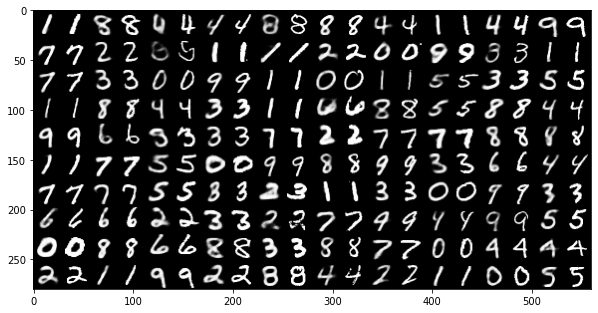

In [20]:
test_reconstruction(model_vae, mnist)

In [21]:
def test_generation(model, z=None, h=28, w=28, batch_size=100):
    # Test the trained model: generation
    # Sample noise vectors from N(0, 1)
    if z is None:
        z = np.random.normal(size=[batch_size, model.n_z])
    x_generated = model.generator(z)    

    n = np.sqrt(batch_size).astype(np.int32)
    I_generated = np.empty((h*n, w*n))
    for i in range(n):
        for j in range(n):
            I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(h, w)
            
    plt.figure(figsize=(8, 8))
    plt.imshow(I_generated, cmap='gray')

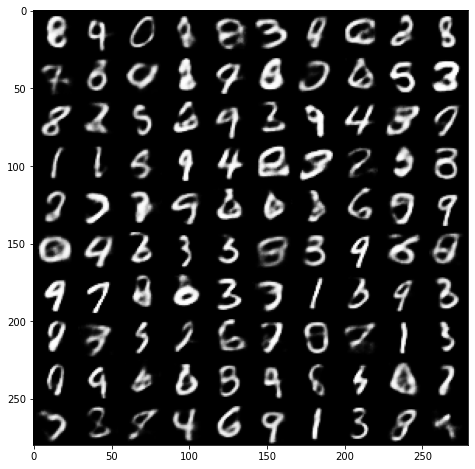

In [22]:
test_generation(model_vae)

In [23]:
# Train a model with 2d latent space
model_vae_2d = trainer(VariantionalAutoencoder, n_z=2)

[Epoch 0] recon_loss: 203.645  latent_loss: 3.386  total_loss: 207.030  (1.608 sec/epoch)
[Epoch 5] recon_loss: 164.253  latent_loss: 4.347  total_loss: 168.599  (1.201 sec/epoch)
[Epoch 10] recon_loss: 156.206  latent_loss: 5.373  total_loss: 161.579  (1.577 sec/epoch)
[Epoch 15] recon_loss: 145.798  latent_loss: 5.190  total_loss: 150.988  (1.233 sec/epoch)
[Epoch 20] recon_loss: 146.528  latent_loss: 5.784  total_loss: 152.312  (1.667 sec/epoch)
[Epoch 25] recon_loss: 150.347  latent_loss: 5.997  total_loss: 156.344  (1.283 sec/epoch)
[Epoch 30] recon_loss: 150.041  latent_loss: 5.866  total_loss: 155.907  (1.834 sec/epoch)
[Epoch 35] recon_loss: 136.031  latent_loss: 5.933  total_loss: 141.964  (1.346 sec/epoch)
[Epoch 40] recon_loss: 145.484  latent_loss: 6.593  total_loss: 152.077  (1.150 sec/epoch)
[Epoch 45] recon_loss: 141.861  latent_loss: 5.946  total_loss: 147.807  (1.641 sec/epoch)
[Epoch 50] recon_loss: 135.548  latent_loss: 6.372  total_loss: 141.920  (1.276 sec/epoch)
[

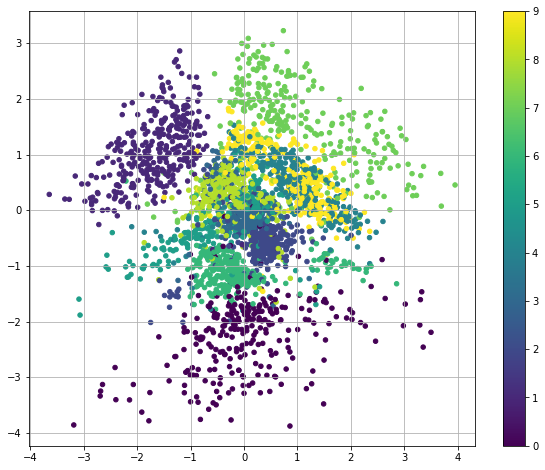

In [24]:
test_transformation(model_vae_2d, mnist)

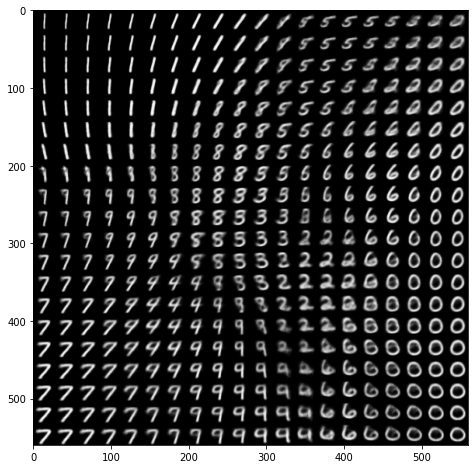

In [25]:
# Test the trained model: uniformly samlpe in the latent space
n = 20
x = np.linspace(-2, 2, n)
y = np.flip(np.linspace(-2, 2, n))
z = []
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        z.append(np.array([xi, yi]))
z = np.stack(z)

# generate images
test_generation(model_vae_2d, z, batch_size=n**2)